In [1]:
import numpy as np
import pandas as pd

In [2]:
Activities = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

In [3]:
DATADIR = 'UCI_HAR_Dataset'

SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [4]:
def csv_read(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            csv_read(filename).as_matrix()
        ) 
    return np.transpose(signals_data, (1, 2, 0))
        
def load_y(subset):
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = csv_read(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [5]:
def load_data():
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, Y_train, Y_test = load_data()

In [7]:
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

C:\Users\hp\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [9]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout

In [10]:
n_epochs = 30
batch_size =16
n_hidden =32

In [11]:
timesteps = len(X_train[1])
input_dim = len(X_train[0][0])
n_classes = 6

print(timesteps)
print(input_dim)
print(len(X_train))
print(n_classes)

128
9
7352
6


In [12]:
model = Sequential()
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
model.add(Dropout(0.5))
model.add(Dense(6,activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [14]:
model.fit(X_train, Y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test,Y_test))

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 44s 6ms/step - loss: 1.3105 - acc: 0.4429 - val_loss: 1.1273 - val_acc: 0.4910
Epoch 2/30
7352/7352 [==============================] - 44s 6ms/step - loss: 0.9807 - acc: 0.5879 - val_loss: 1.0065 - val_acc: 0.5874
Epoch 3/30
7352/7352 [==============================] - 45s 6ms/step - loss: 0.8340 - acc: 0.6375 - val_loss: 0.7764 - val_acc: 0.6261
Epoch 4/30
7352/7352 [==============================] - 44s 6ms/step - loss: 0.7218 - acc: 0.6578 - val_loss: 0.7612 - val_acc: 0.5962
Epoch 5/30
7352/7352 [==============================] - 44s 6ms/step - loss: 0.8193 - acc: 0.6261 - val_loss: 0.9435 - val_acc: 0.5389
Epoch 6/30
7352/7352 [==============================] - 76s 10ms/step - loss: 0.7005 - acc: 0.6545 - val_loss: 0.7645 - val_acc: 0.6244
Epoch 7/30
7352/7352 [==============================] - 96s 13ms/step - loss: 0.6373 - acc: 0.6868 - val_loss: 0.7128 - val_acc: 0.6396
Epoch

In [15]:
Y_pred = model.predict(X_test)
    y_pred = pd.Series([Activities[y] for y in np.argmax(Y_pred, axis=1)])

    y_test = pd.Series([Activities[y] for y in np.argmax(Y_test, axis=1)])

[[534   3   0   0   0   0]
 [  2 416  71   0   0   2]
 [  0 118 413   1   0   0]
 [  0   1   0 480  11   4]
 [  0   0   0   9 402   9]
 [  0   1   2  60   9 399]]


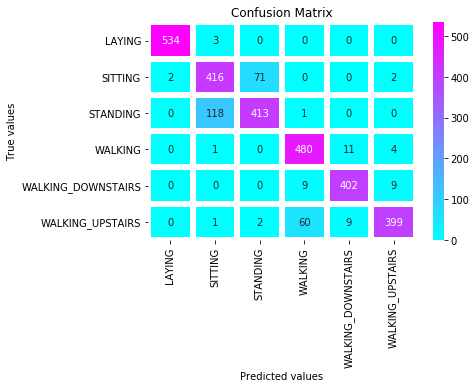

In [18]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred)
print(cm)
labels=['LAYING', 'SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']
cm_df = pd.DataFrame(cm,index=labels, columns =labels)

import matplotlib.pyplot as plt
import seaborn as sns

#plt.figure(figsize=(8,8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='cool', linewidth=5)
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.xticks(rotation=90)
plt.title('Confusion Matrix')
plt.show()

In [19]:
score = model.evaluate(X_test, Y_test)
print("Accuracy = ", score[1]*100)

2947/2947 [==============================] - 2s 619us/step


[0.34830292502909893, 0.8971835765387189]